### Name: Patricia Geppert
### UTSA ID: von990


# Reddit GME Posts and Comments analysis
### Observations:
1.  In late November 2020, there were periodic increases in the number of Reddit comments that mentioned GameStop (GME).  (what was the normal average number of posts and what is the enhanced number of posts?)
2.  Increase in commnets mentioning GME was associated with increase in trading volume of GME stock

### Questions:
1.  What was it about the text of the posts and comments that may have influenced stock purchases?
2.  Common words in high volume comments vs. normal comments (Word Cloud)
3.  Sentiment Analysis (NLTK)
4.  Can the high-volume and normal volume comments be distinquished via Supervised Machine Learning? Decision Tree/    Random Forest.



In [2]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import re
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.lines as mlines

C:\Users\patri\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [8]:
#load Comments_processed json file into pandas dataframe
cdf = pd.read_json('comment_processed.txt', orient = 'records')
cdf


,Score,Date,Comment
0,1,2021-02-20,WSB has already become a hive mind in regards ...
1,1,2021-02-20,Everybody knew about a multi trillion dollar d...
2,1,2021-02-20,"They likely are selling puts, not buying them...."
3,1,2021-02-20,Coin plus GME gang
4,1,2021-02-20,I started this year and slowly added throughou...
...,...,...,...
642104,1,2014-11-21,"Don't buy, the trend is clear, more and more v..."
642105,1,2014-03-14,I don't like any form of retail right now. In ...
642106,1,2014-03-14,Wow I do the same thing. I'm looking at buyin...
642107,2,2014-01-02,"Q1 is usually a time when laggards do well, I'..."


In [9]:
# slice dates 08-31-2020 to 2-20-21
cdf_new = cdf.copy()
cdf_new = cdf[cdf['Date']> '2020-08-31']
cdf_new

,Score,Date,Comment
0,1,2021-02-20,WSB has already become a hive mind in regards ...
1,1,2021-02-20,Everybody knew about a multi trillion dollar d...
2,1,2021-02-20,"They likely are selling puts, not buying them...."
3,1,2021-02-20,Coin plus GME gang
4,1,2021-02-20,I started this year and slowly added throughou...
...,...,...,...
634677,1,2020-09-01,"Friendship with TSLA ended, best friends with ..."
634678,2,2020-09-01,"The guy who bought 10% of GME, also bought bil..."
634679,1,2020-09-01,"Gamestop already tried mobile, they failed at ..."
634680,1,2020-09-01,"I have had shares of GME get called away, norm..."


In [12]:
#Tokenize comments text
#cdf_new['tokenized_text']=[simple_preprocess(line, deacc=True) for line in cdf_new.loc[:,'Comment']]
cdf_new['tokenized_text']=[simple_preprocess(line, deacc=True) for line in cdf_new['Comment']]
cdf_new.head()

<ipython-input-12-319097b87ac8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_new['tokenized_text']=[simple_preprocess(line, deacc=True) for line in cdf_new['Comment']]


,Score,Date,Comment,tokenized_text
0,1,2021-02-20,WSB has already become a hive mind in regards ...,"[wsb, has, already, become, hive, mind, in, re..."
1,1,2021-02-20,Everybody knew about a multi trillion dollar d...,"[everybody, knew, about, multi, trillion, doll..."
2,1,2021-02-20,"They likely are selling puts, not buying them....","[they, likely, are, selling, puts, not, buying..."
3,1,2021-02-20,Coin plus GME gang,"[coin, plus, gme, gang]"
4,1,2021-02-20,I started this year and slowly added throughou...,"[started, this, year, and, slowly, added, thro..."


In [13]:
#cdf_new.to_csv('comments_tokenized.csv')
#cdf_new = pd.read_csv('comments_tokenized.csv')

In [16]:
#Calculating the number of comments per date
comment_freq = pd.DataFrame(cdf_new.groupby('Date').size())
comment_freq.rename(columns = {0:"Num_Comments"},inplace = True)
comment_freq


,Num_Comments
Date,
2020-09-01,50
2020-09-02,51
2020-09-03,54
2020-09-04,12
2020-09-05,18
...,...
2021-02-16,899
2021-02-17,2508
2021-02-18,5693


In [16]:
#Average number of comments on high-volume and normal volume comments days
high_count = 0
high_total = 0
normal_count = 0
normal_total = 0
for i,num in comment_freq['Num_Comments'].iteritems():
    if num > 1000:
        high_count += 1
        high_total = high_total + num
    else:
        normal_count +=1
        normal_total = normal_total + num
high_average = high_total/high_count
normal_average = normal_total/normal_count

print ('The number of days with high-volume posts is {} and the average number of posts per day is {:.2f}'.format(high_count,high_average))
print ('The number of days with normal-volume posts is {} and the average number of posts per day is {:.2f}'.format(normal_count,normal_average))

The number of days with high-volume posts is 54 and the average number of posts per day is 11119.43
The number of days with normal-volume posts is 113 and the average number of posts per day is 302.10


In [14]:
#Preparing the comment dataframe to join the comments per date information
cdf_indexed = cdf_new.copy()
cdf_indexed = cdf_indexed.set_index('Date')
cdf_indexed

,Score,Comment,tokenized_text
Date,,,
2021-02-20,1,WSB has already become a hive mind in regards ...,"[wsb, has, already, become, hive, mind, in, re..."
2021-02-20,1,Everybody knew about a multi trillion dollar d...,"[everybody, knew, about, multi, trillion, doll..."
2021-02-20,1,"They likely are selling puts, not buying them....","[they, likely, are, selling, puts, not, buying..."
2021-02-20,1,Coin plus GME gang,"[coin, plus, gme, gang]"
2021-02-20,1,I started this year and slowly added throughou...,"[started, this, year, and, slowly, added, thro..."
...,...,...,...
2020-09-01,1,"Friendship with TSLA ended, best friends with ...","[friendship, with, tsla, ended, best, friends,..."
2020-09-01,2,"The guy who bought 10% of GME, also bought bil...","[the, guy, who, bought, of, gme, also, bought,..."
2020-09-01,1,"Gamestop already tried mobile, they failed at ...","[gamestop, already, tried, mobile, they, faile..."


In [17]:
#Joinng comment dataframe to join the comments per date information
cdf_joined =cdf_new.join(comment_freq, on='Date', rsuffix='_r')
cdf_joined

,Score,Date,Comment,tokenized_text,Num_Comments
0,1,2021-02-20,WSB has already become a hive mind in regards ...,"[wsb, has, already, become, hive, mind, in, re...",2380
1,1,2021-02-20,Everybody knew about a multi trillion dollar d...,"[everybody, knew, about, multi, trillion, doll...",2380
2,1,2021-02-20,"They likely are selling puts, not buying them....","[they, likely, are, selling, puts, not, buying...",2380
3,1,2021-02-20,Coin plus GME gang,"[coin, plus, gme, gang]",2380
4,1,2021-02-20,I started this year and slowly added throughou...,"[started, this, year, and, slowly, added, thro...",2380
...,...,...,...,...,...
634677,1,2020-09-01,"Friendship with TSLA ended, best friends with ...","[friendship, with, tsla, ended, best, friends,...",50
634678,2,2020-09-01,"The guy who bought 10% of GME, also bought bil...","[the, guy, who, bought, of, gme, also, bought,...",50
634679,1,2020-09-01,"Gamestop already tried mobile, they failed at ...","[gamestop, already, tried, mobile, they, faile...",50
634680,1,2020-09-01,"I have had shares of GME get called away, norm...","[have, had, shares, of, gme, get, called, away...",50


In [18]:
#Classifiying days as either "high-volume" comment days = 1, if more than 1000 comments per day.  
#'Normal-volume' comment days = 0
rating = []
for i,value in cdf_joined['Num_Comments'].iteritems():
    if value > 1000:
        rate=1
    else:
        rate=0
    rating.append(rate)

cdf_joined["Rating"]=rating


In [19]:
#Isolating the "high-volume" days to create a Word Cloud to visualize relative frequency of words on high-volume days.
hdf = cdf_joined.copy()
high_volume = hdf['Rating'] ==1
hdf = hdf[high_volume]



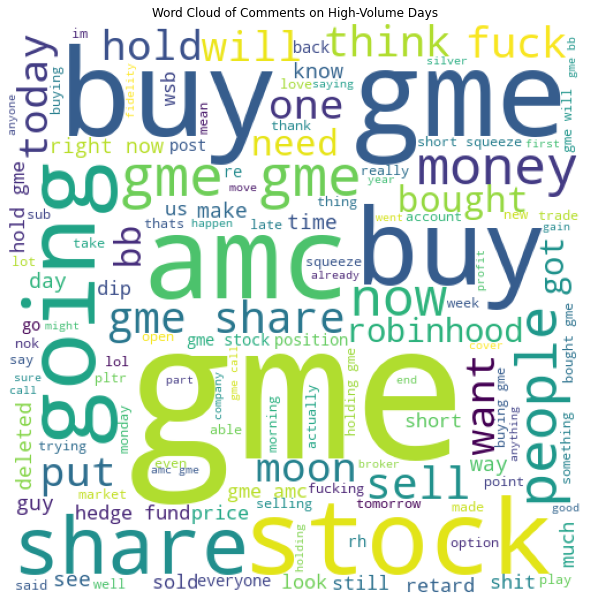

In [20]:
#WordCloud of High-Volume Comments
comment_words = ''
stopwords = set(STOPWORDS)


# iterate through the csv file
for tokens in hdf.tokenized_text:
      
    comment_words += " ".join(tokens)+" "
  
hwc = WordCloud(width = 500, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(hwc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud of Comments on High-Volume Days')   
plt.show()

In [37]:
hwc.to_file('high_wc.png')

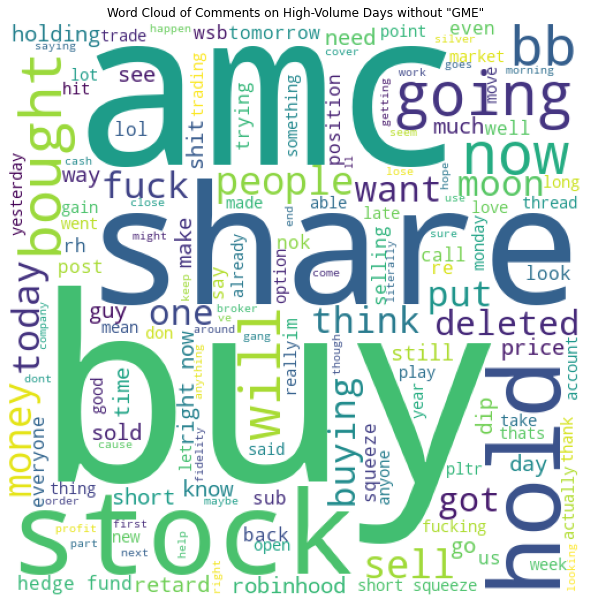

In [38]:
#WordCloud of High-Volume Comments without the word 'gme'
comment_words = ''
stopwords = set(STOPWORDS)
stopwords.update(['gme'])


# iterate through the csv file
for tokens in hdf.tokenized_text:

    comment_words += " ".join(tokens)+" "
  
hwc_gme = WordCloud(width = 500, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(hwc_gme)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud of Comments on High-Volume Days without "GME"') 
plt.show()

In [39]:
hwc_gme.to_file('high_wc_gme.png')

In [28]:
#Preparing Normal-volume day comments for Word Cloud
ndf = cdf_joined.copy()
norm_volume = ndf['Rating'] ==0
ndf = ndf[norm_volume]
ndf

,Score,Date,Comment,tokenized_text,Num_Comments,Rating
14458,1,2021-02-16,Are you me? Held GME too long and went from a ...,"[are, you, me, held, gme, too, long, and, went...",899,0
14459,1,2021-02-16,You can rebuild your portfolio. You got your s...,"[you, can, rebuild, your, portfolio, you, got,...",899,0
14460,1,2021-02-16,I think you think we think gme is a good inves...,"[think, you, think, we, think, gme, is, good, ...",899,0
14461,1,2021-02-16,"IDK. I just short sold 1000 GME this morning, ...","[idk, just, short, sold, gme, this, morning, c...",899,0
14462,1,2021-02-16,"Cool. Now do analysis of when GME FTDs fell, w...","[cool, now, do, analysis, of, when, gme, ftds,...",899,0
...,...,...,...,...,...,...
634677,1,2020-09-01,"Friendship with TSLA ended, best friends with ...","[friendship, with, tsla, ended, best, friends,...",50,0
634678,2,2020-09-01,"The guy who bought 10% of GME, also bought bil...","[the, guy, who, bought, of, gme, also, bought,...",50,0
634679,1,2020-09-01,"Gamestop already tried mobile, they failed at ...","[gamestop, already, tried, mobile, they, faile...",50,0
634680,1,2020-09-01,"I have had shares of GME get called away, norm...","[have, had, shares, of, gme, get, called, away...",50,0


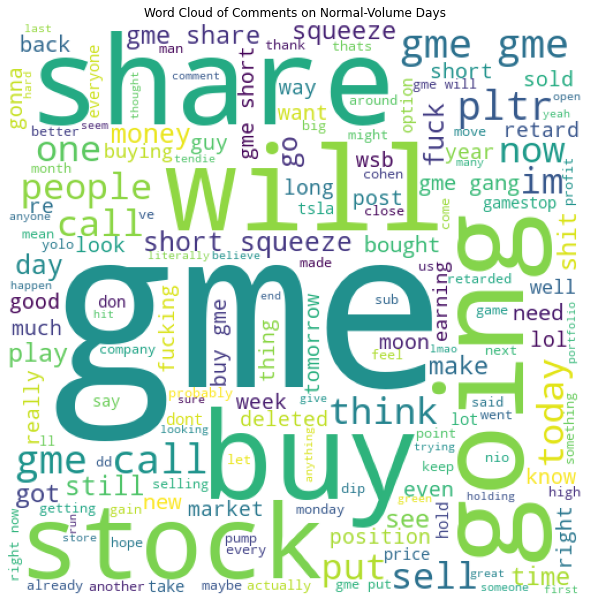

In [40]:
#WordCloud of normal-volume Comments
comment_words = ''
stopwords = set(STOPWORDS)



# iterate through the csv file
for tokens in ndf.tokenized_text:

    comment_words += " ".join(tokens)+" "
  
nwc = WordCloud(width = 500, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(nwc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud of Comments on Normal-Volume Days')    
plt.show()

In [41]:
nwc.to_file('norm_wc.png')

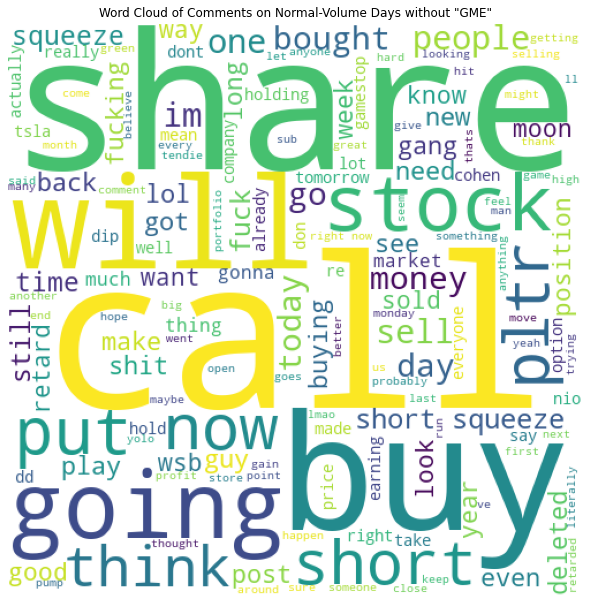

In [42]:
#WordCloud of normal-volume Comments without "GME"
comment_words = ''
stopwords = set(STOPWORDS)
stopwords.update(['gme'])


# iterate through the csv file
for tokens in ndf.tokenized_text:
       
    comment_words += " ".join(tokens)+" "
  
nwc_gme = WordCloud(width = 500, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(nwc_gme)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud of Comments on Normal-Volume Days without "GME"')    
plt.show()

In [43]:
nwc_gme.to_file('norm_wc_gme.png')

In [21]:
#NLTK Sentiment Analysis using VADER

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
polar_score = []
for i,text in cdf_joined['Comment'].iteritems():
    score = sia.polarity_scores (text)
    polar_score.append(score['compound'])

cdf_joined["sentiment_compound"] = polar_score

In [44]:
sdf=cdf_joined.copy()
sdf= sdf.groupby('Date').agg({"sentiment_compound" : 'mean'})

sdf = sdf.join([comment_freq])
sdf

,sentiment_compound,Num_Comments
Date,,
2020-09-01,0.123240,50
2020-09-02,0.107075,51
2020-09-03,0.024150,54
2020-09-04,0.133508,12
2020-09-05,0.112472,18
...,...,...
2021-02-16,0.035420,899
2021-02-17,0.041005,2508
2021-02-18,0.022453,5693


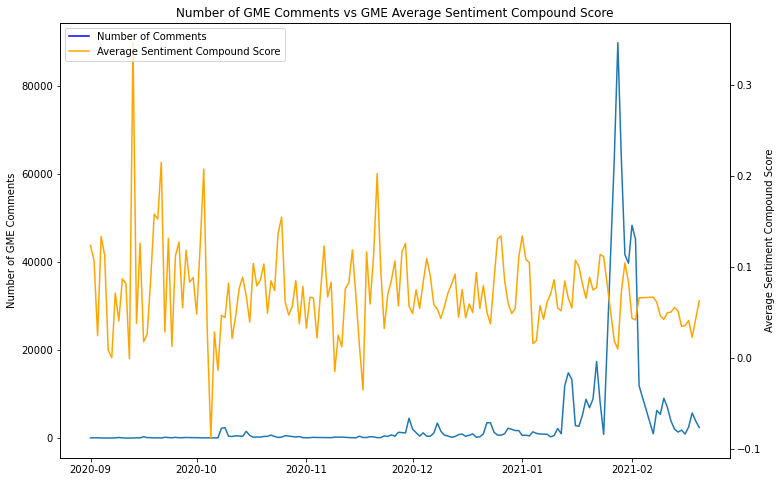

In [46]:
#graph of average 'Number of GME Comments vs GME Average Sentiment Compound Score' by date 
blue_line = mlines.Line2D([],[], color = 'blue', label = 'Number of Comments') 
orange_line = mlines.Line2D([],[], color = 'orange', label = 'Average Sentiment Compound Score') 
fig, ax1 = plt.subplots(figsize = (12,8))
ax2 = ax1.twinx()
ax1.plot(sdf.index, sdf['Num_Comments'], label = 'Number of Comment')
ax2.plot(sdf.index, sdf['sentiment_compound'], color = 'orange', label = "Average Sentiment Compound Score" )
ax1.set_title('Number of GME Comments vs GME Average Sentiment Compound Score')
ax1.set_ylabel('Number of GME Comments')
ax2.set_ylabel('Average Sentiment Compound Score')

plt.legend(handles = [blue_line,orange_line], loc = 2);

### Preparing the data for Machine Learning
## Data Preprocessing
1. Tokenized and stemmed.  Did not remove stop words
2.  Added number of comments on that date and rating for number of comments (1: >1000 comments, 0:<1000 comments)
3. Sliced data.  Only used data from 09-01-2020 to 02-20-2021
4.  Balanced Data set (randomly selected 34137 of 600234 the 1 rated comments to match the 0 rated comments. 
4.  Vectorized using Words2Vec
5.  80% train, 20% test

In [32]:
#Number of hig-volume days (1) vs normal volume days (0)
cdf_joined['Rating'].value_counts()

1    600449
0     34137
Name: Rating, dtype: int64

In [25]:
#balance the datasets
cdf_balanced = cdf_joined.groupby('Rating').apply(lambda x: x.sample(n=34137)).reset_index(drop = True)
cdf_balanced['Rating'].value_counts()

0    34137
1    34137
Name: Rating, dtype: int64

In [23]:
#cdf_balanced.to_csv('Comments_balanced.csv')

In [26]:
#cdf_balanced = pd.read_csv('Comments_balanced.csv')
#cdf_balanced["Date"]=pd.to_datetime(df_bal["Date"])
cdf_balanced.head()

,Score,Date,Comment,tokenized_text,Num_Comments,Rating,sentiment_compound
0,5,2021-01-06,If GME goes up to a dollar my dick will litera...,"[if, gme, goes, up, to, dollar, my, dick, will...",917,0,-0.5106
1,5,2021-01-02,"GME to the moon, whether you like it or not","[gme, to, the, moon, whether, you, like, it, o...",660,0,0.3612
2,6,2020-12-15,Cramer mentioned GME? Well with a pump there a...,"[cramer, mentioned, gme, well, with, pump, the...",896,0,0.5423
3,7,2021-01-06,My GME play went from big green to little red.,"[my, gme, play, went, from, big, green, to, li...",917,0,0.3400
4,1,2020-10-12,Everyone sold GME at open. Now it can moon,"[everyone, sold, gme, at, open, now, it, can, ...",517,0,0.0000


In [28]:
#stemming the tokens
porter_stemmer = PorterStemmer()
cdf_balanced['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in cdf_balanced['tokenized_text']]
cdf_balanced['stemmed_tokens'].head()


0    [if, gme, goe, up, to, dollar, my, dick, will,...
1    [gme, to, the, moon, whether, you, like, it, o...
2    [cramer, mention, gme, well, with, pump, there...
3    [my, gme, plai, went, from, big, green, to, li...
4    [everyon, sold, gme, at, open, now, it, can, m...
Name: stemmed_tokens, dtype: object

In [30]:
# 2 - Vectorize using word2vec
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

word2vec_model_file = 'word2vec_'+str(size)+'.model'
stemmed_tokens = pd.Series(cdf_balanced['stemmed_tokens']).values
w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, vector_size = size, window = window, workers = workers, sg = sg)

w2v_model.save(word2vec_model_file)

In [31]:
#split data into train and test datasets
X_train,X_test,Y_train,Y_test = train_test_split(cdf_balanced[['stemmed_tokens',"sentiment_compound" ]], 
                                                        cdf_balanced['Rating'], 
                                                        test_size=.2)
   
X_train = X_train.reset_index()
X_test = X_test.reset_index()
Y_train = Y_train.to_frame()
Y_train = Y_train.reset_index()
Y_test = Y_test.to_frame()
Y_test = Y_test.reset_index()


In [32]:
X_train.head()

,index,stemmed_tokens,sentiment_compound
0,29241,"[spent, of, it, on, gme, share, whenev, the, m...",0.2960
1,60580,"[would, gladli, bui, gme, but, robinhood, ha, ...",-0.3178
2,36904,"[read, thi, again, to, not, paper, hand, out, ...",-0.3875
3,30297,"[mt, gme]",0.0000
4,47082,"[look, like, gme, and, amc, is, over, mayb, it...",0.3612


In [34]:
#Vectorizing the training dataset
word2vec_filename = 'new_train_review_word2vec.csv'
sg_w2v_model = Word2Vec.load(word2vec_model_file)

with open(word2vec_filename, 'w+') as word2vec_file:
    for index,row in X_train.iterrows():
        model_vector = (np.mean([sg_w2v_model.wv[token] for token in row['stemmed_tokens']],axis = 0)).tolist()
        if index ==0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write('\n')
        if type(model_vector) is list:
            line1 = ','.join([str(vector_element) for vector_element in model_vector])
        else:
            line1=','.join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

C:\Users\patri\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\patri\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Decision Tree Classifier

In [35]:
#4 - Train the DecisionTreeClassifier over the train set
from sklearn.tree import DecisionTreeClassifier
train_data = pd.read_csv('new_train_review_word2vec.csv')
decision_tree = DecisionTreeClassifier()

decision_tree.fit(train_data,Y_train['Rating'])

DecisionTreeClassifier()

In [36]:
#5 - Predict the labels of the test set using the trained model
word2vec_filename = 'new_test_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index,row in X_test.iterrows():
        model_vector = (np.mean([sg_w2v_model.wv[token] for token in row['stemmed_tokens']],axis = 0)).tolist()
        if index ==0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write('\n')
        if type(model_vector) is list:
            line1 = ','.join([str(vector_element) for vector_element in model_vector])
        else:
            line1=','.join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')
        
test_data = pd.read_csv('new_test_review_word2vec.csv')


predictions = decision_tree.predict(test_data)


C:\Users\patri\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\patri\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [37]:

print(classification_report(Y_test['Rating'], predictions))
#8 - Confusion Matrix
tn,fp,fn,tp = confusion_matrix(Y_test['Rating'], predictions).ravel()
print("TP", tp, "TN", tn, "FP", fp, "FN", fn)
print(confusion_matrix(Y_test['Rating'], predictions))

              precision    recall  f1-score   support

           0       0.60      0.59      0.60      6838
           1       0.60      0.60      0.60      6817

    accuracy                           0.60     13655
   macro avg       0.60      0.60      0.60     13655
weighted avg       0.60      0.60      0.60     13655

TP 4117 TN 4065 FP 2773 FN 2700
[[4065 2773]
 [2700 4117]]


## Logistic Regression Classification
1.  Use preprocessed data from above
2

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
train_data = pd.read_csv('new_train_review_word2vec.csv')
test_data = pd.read_csv('new_test_review_word2vec.csv')

lg_class = LogisticRegression(random_state = 0, max_iter = 500, solver = 'liblinear' )
lg_class.fit(train_data,Y_train['Rating'])
lg_class_prediction = lg_class.predict(test_data)

print(classification_report(Y_test["Rating"], lg_class_prediction))

cfr = classification_report(Y_test["Rating"], lg_class_prediction, output_dict = True)


              precision    recall  f1-score   support

           0       0.68      0.69      0.69      6838
           1       0.69      0.68      0.68      6817

    accuracy                           0.69     13655
   macro avg       0.69      0.69      0.69     13655
weighted avg       0.69      0.69      0.69     13655



In [41]:
tn,fp,fn,tp = confusion_matrix(Y_test['Rating'], lg_class_prediction).ravel()
print("TP", tp, "TN", tn, "FP", fp, "FN", fn)
print(confusion_matrix(Y_test['Rating'], lg_class_prediction))

TP 4618 TN 4741 FP 2097 FN 2199
[[4741 2097]
 [2199 4618]]
